## BloomTech Data Science

---

# Permutation & Boosting

- Get **permutation importances** for model interpretation and feature selection
- Use xgboost for **gradient boosting**

# Downloading the Tanzania Waterpump Dataset

Make sure  you only use the dataset that is available through the **DS** **Kaggle Competition**. DO NOT USE any other Tanzania waterpump datasets that you might find online.

There are two ways you can get the dataset. Make sure you have joined the competition first!:

1. You can download the dataset directly by accessing the challenge and the files through the Kaggle Competition URL on Canvas (make sure you have joined the competition!)

2. Use the Kaggle API using the code in the following cells. This article provides helpful information on how to fetch your Kaggle Dataset into Google Colab using the Kaggle API.

> https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a

# Using Kaggle API to download datset

In [1]:
# mounting your google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#change your working directory, if you want to or have already saved your kaggle dataset on google drive.
%cd /content/gdrive/My Drive/Kaggle
# update it to your folder location on drive that contains the dataset and/or kaggle API token json file.

/content/gdrive/My Drive/Kaggle


In [ ]:
# Download your Kaggle Dataset, if you haven't already done so.
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# !kaggle competitions download -c bloomtech-water-pump-challenge # double check if this command corresponds with the one given in Canvas

In [ ]:
# Unzip your Kaggle dataset, if you haven't already done so.
# !unzip \*.zip  && rm *.zip

In [3]:
# List all files in your Kaggle folder on your google drive.
!ls

2025-08-08_2143_submission.csv	model_8043		 test_features.csv
2025-08-11_1658_submission.csv	model_rf_rs_80		 train_features.csv
breast_cancer_model_rf_9649	new_submission.csv	 train_labels.csv
dt_new_submission.csv		rf_water_submission.csv
kaggle.json			sample_submission.csv


# Install Libraries

In [4]:
%%capture
!pip install category_encoders==2.*

In [14]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# encoders
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer

#pipeline
from sklearn.pipeline import make_pipeline

# Bagged Model
from sklearn.ensemble import RandomForestClassifier

# Boosted Models
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Label encoder for XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Permutation Importance
from sklearn.inspection import permutation_importance

# for displaying images and html
from IPython.display import Image
from IPython.core.display import HTML

# Wrangle Data

We'll go back to Tanzania Waterpumps for this lesson.

In [6]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, parse_dates=['date_recorded'], na_values=[-2e-08, 0]),
                         pd.read_csv(tv_path)).set_index('date_recorded')

    else:
        df = pd.read_csv(fm_path, parse_dates=['date_recorded']).set_index('date_recorded')

    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because of the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year',
                       'gps_height', 'population']
    for col in cols_with_zeros:
        df[col] = df[col].replace(0, np.nan)
        df[col+'_MISSING'] = df[col].isnull()

    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    df = df.drop(columns=duplicates)

    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    df = df.drop(columns=unusable_variance)

    # Extract components from date_recorded
    df['year_recorded'] = df.index.year
    df['month_recorded'] = df.index.month
    df['day_recorded'] = df.index.day

    # Engineer feature: how many years from construction_year to date_recorded
    df['pump_age'] = df['year_recorded'] - df['construction_year']
    df['years_MISSING'] = df['pump_age'].isnull()

    # return the wrangled dataframe
    return df

In [7]:
fm_path = 'train_features.csv'
tv_path = 'train_labels.csv'

df = wrangle(fm_path, tv_path)

In [8]:
# Split data into feature and target
target = 'status_group'
X, y = df.drop(columns = target), df[target]

In [9]:
# Split data into train, validation and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)

In [10]:
# Baseline Metric
print('The baseline accuracy is ', y_train.value_counts(normalize=True).max())

The baseline accuracy is  0.5425489938182296


# Build Model

In [11]:
# Random Forest Model

model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=42, n_jobs=-1,n_estimators=75)
)

# Fit on train, score on val
model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source',...
improved spring                4
other                          5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': hand pump             1
communal standpipe    2
improved spring       3
other                 4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=75, n_jobs=-1,
                                        random_state=42))])

In [12]:
# Gradient Boosted Model

model_gb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    GradientBoostingClassifier(random_state=42, n_estimators=75)
)

model_gb.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source',...
communal standpipe multiple    3
improved spring                4
other                          5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': hand pump             1
communal standpipe    2
improved spring       3
other                 4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(n_estimators=75, random_state=42))])

In [15]:
# XGB Model
# extreme gradient boosting

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)

model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=42, n_estimators=75, n_jobs=-1)
)

model_xgb.fit(X_train, y_train_encoded)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source',...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=75, n_jobs=-1,
                               num_parallel_tree=None, ...))])

# Check Metrics

In [16]:
print('Training Accuracy', model_rf.score(X_train, y_train))
print('Validation Accuracy', model_rf.score(X_val, y_val))

Training Accuracy 0.9998947783769565
Validation Accuracy 0.8034511784511784


In [17]:
print('Training Accuracy', model_gb.score(X_train, y_train))
print('Validation Accuracy', model_gb.score(X_val, y_val))

Training Accuracy 0.7531763777456267
Validation Accuracy 0.7413720538720538


In [18]:
print('Training Accuracy', model_xgb.score(X_train, y_train_encoded))
print('Validation Accuracy', model_xgb.score(X_val, label_encoder.fit_transform(y_val)))

Training Accuracy 0.8449559384453506
Validation Accuracy 0.7889309764309764


### Try adjusting these hyperparameters

#### Random Forest
- class_weight (for imbalanced classes)
- max_depth (usually high, can try decreasing)
- n_estimators (too low underfits, too high wastes time)
- min_samples_leaf (increase if overfitting)
- max_features (decrease for more diverse trees)

#### Xgboost
- scale_pos_weight (for imbalanced classes)
- max_depth (usually low, can try increasing)
- n_estimators (too low underfits, too high wastes time/overfits) — Use Early Stopping!
- learning_rate (too low underfits, too high overfits)

For more ideas, see [Notes on Parameter Tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html) and [DART booster](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html).

# Tuning / Communication

- How can we determine or communicate which features are most important to our model when making predictions?

**Option 1:** Grab feature importances from our pipeline


Text(0, 0.5, 'Feature')

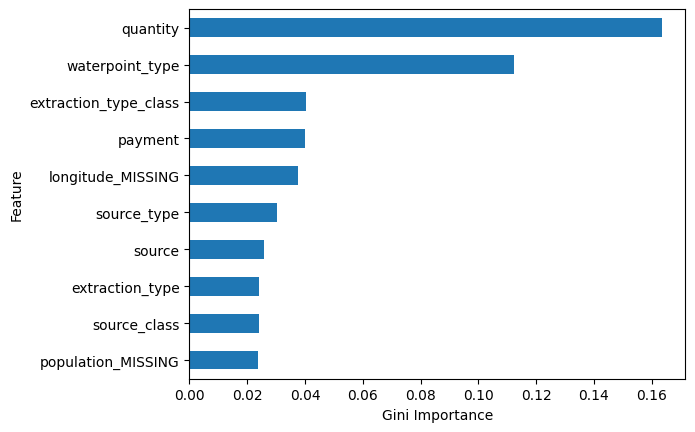

In [19]:
importances = model_xgb.named_steps['xgbclassifier'].feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')

**Option 2:** Drop-column Importance


In [20]:
selected_column = 'quantity'

In [22]:
model_with_col = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=75,
                  random_state=42,
                  n_jobs=-1,)
)

model_with_col.fit(X_train, y_train_encoded)

print(f'Validation Accuracy w/ "{selected_column}" included:', model_with_col.score(X_val, label_encoder.fit_transform(y_val)))

Validation Accuracy w/ "quantity" included: 0.7889309764309764


In [23]:
model_without_col = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=75,
                  random_state=42,
                  n_jobs=-1,)
)

model_without_col.fit(X_train.drop(columns=selected_column), y_train_encoded)


print(f'Validation Accuracy w/ "{selected_column}" excluded:', model_without_col.score(X_val.drop(columns=selected_column), label_encoder.fit_transform(y_val)))

Validation Accuracy w/ "quantity" excluded: 0.7582070707070707


**Option 3:** Permutation Importance

![](https://i.imgur.com/h17tMUU.png)

In [24]:
# By hand

# Step 1: Choose my feature
column_to_permute = 'quantity'

# Step 2: Train model w/ ALL features
model_to_permute = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=75,
                  random_state=42,
                  n_jobs=-1,)
)

model_to_permute.fit(X_train, y_train_encoded);

In [25]:
# Step 3: Evaluate model using VALIDATION DATA.
print('Validation Accuracy', model_to_permute.score(X_val, label_encoder.fit_transform(y_val)))

Validation Accuracy 0.7889309764309764


In [26]:
# Step 4: In VALIDATION DATA, permute the feature we're evaluating
X_val_perm = X_val.copy()
X_val_perm[column_to_permute] = np.random.permutation(X_val_perm[column_to_permute])

In [27]:
# Step 5: Calculate our error metric with the permuted data
print('Validation Accuracy', model_to_permute.score(X_val_perm, label_encoder.fit_transform(y_val)))

Validation Accuracy 0.6927609427609428


In [29]:
# Automated using sklearn

perm_imp = permutation_importance(model_to_permute, X_val, label_encoder.fit_transform(y_val), random_state=42) # n_repeats=5 is the default

In [30]:
perm_imp

{'importances_mean': array([ 3.38804714e-03,  8.58585859e-03,  7.55471380e-03,  3.80892256e-03,
         1.29840067e-02,  1.40993266e-02, -3.15656566e-04, -4.20875421e-05,
         3.55639731e-03,  2.31481481e-03,  2.42003367e-03,  9.04882155e-04,
         4.18771044e-03,  1.12373737e-02,  6.67087542e-03,  1.21632997e-02,
         6.03956229e-03,  2.77777778e-03,  7.38636364e-03,  2.16750842e-03,
         8.98569024e-03,  1.25631313e-02,  1.34680135e-03,  8.71212121e-03,
         5.47138047e-03,  2.10437710e-04,  2.41582492e-02,  1.51515152e-03,
         1.57828283e-03,  9.78114478e-02,  5.68181818e-03,  1.64141414e-03,
         2.04124579e-03,  3.25757576e-02,  0.00000000e+00,  4.12457912e-03,
         0.00000000e+00,  2.10437710e-04,  6.73400673e-04, -2.52525253e-04,
         0.00000000e+00,  3.49326599e-03,  4.73484848e-03,  5.30303030e-03,
         0.00000000e+00]),
 'importances_std': array([0.00090855, 0.00088183, 0.00096526, 0.00062213, 0.00211445,
        0.00140222, 0.00064861

In [31]:
data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}
df_perm = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean')

In [32]:
df_perm

,imp_mean,imp_std
wpt_name,-0.000316,0.000649
population_MISSING,-0.000253,0.000374
num_private,-0.000042,0.000157
waterpoint_type_group,0.000000,0.000000
year_recorded,0.000000,0.000405
latitude_MISSING,0.000000,0.000000
years_MISSING,0.000000,0.000000
management_group,0.000210,0.000133
construction_year_MISSING,0.000210,0.000240
gps_height_MISSING,0.000673,0.000107


<Axes: >

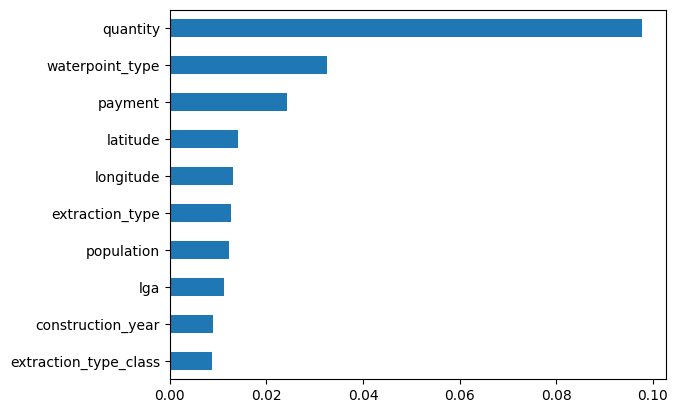

In [33]:
df_perm['imp_mean'].tail(10).plot(kind='barh')
